# CSE 574 Introduction to Machine Learning Fall 2019 Project 3
# Clustering Fashion Clothing Images using Unsupervised Learning
## Srisai Karthik Neelamraju, neelamra@buffalo.edu

### Importing the required libraries

In [0]:
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import keras
from keras.datasets import fashion_mnist
from keras.models import Input, Model
from tensorflow import set_random_seed

np.random.seed(1)
set_random_seed(10)

Using TensorFlow backend.


### Helper Functions

In [0]:
# function to calculate accuracy
def get_accuracy(Y_expected, Y_pred):
  return metrics.accuracy_score(Y_expected, Y_pred)

# function to calculate confusion matrix
def get_confusion_matrix(Y_expected, Y_pred):
  return metrics.confusion_matrix(Y_expected, Y_pred)

# function to adjust the predicted labels
def get_adjusted_labels(Y_expected, Y_pred):
  conf_mtx = get_confusion_matrix(Y_expected, Y_pred).T
  adjusted_labels = linear_sum_assignment(conf_mtx.max() - conf_mtx)[1]
  # replacing the labels 0 to 9 with 10 to 19
  for i in range(10):
    Y_pred = np.where(Y_pred == i, i + 10, Y_pred)
  # replacing the labels 10 to 19 with the adjusted ones
  for i in range(10):
    Y_pred = np.where(Y_pred == i + 10, adjusted_labels[i], Y_pred)
  return Y_pred, adjusted_labels

### Reading the Fashion MNIST dataset

In [0]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# finding the number of training and test set instances
n_train = X_train.shape[0]
n_test = X_test.shape[0]

4423680/4422102 [==============================] - 0s 0us/step


### Preprocessing the dataset

In [0]:
# min-max scaling of the features
X_train = X_train / 255.0
X_test = X_test / 255.0

# flattening the 28 x 28 input images
X_train = X_train.reshape(n_train, 784)
X_test = X_test.reshape(n_test, 784)

### Reshaping the testing data

In [0]:
# reshaping Y_train and Y_test to get rid of rank 1 Python arrays
Y_train = np.array(Y_train).reshape(n_train, 1)
Y_test = np.array(Y_test).reshape(n_test, 1)

## Task 1: Using K-Means to cluster the Fashion MNIST data space

### Defining the initial parameters

In [0]:
# default number of clusters
n_clusters = 10

# maximum value for number of clusters
max_clusters = 25

### Implementing K-Means algorithm

In [0]:
# list to keep track of sum of squared errors on the training set
sse_train = []

# trying k-means for different values of n_clusters around 10
for n in range(1, max_clusters + 1):
  kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
  kmeans.fit(X_train)
  sse_train.append(kmeans.inertia_)

### Plotting the SSE for different number of clusters

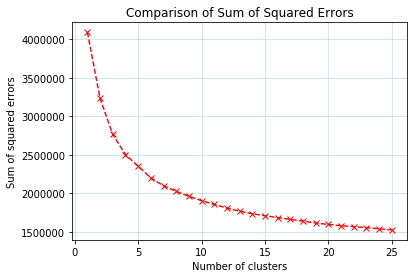

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(1, max_clusters + 1), sse_train, color='red', marker='x', linestyle='dashed', linewidth=1.4)
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of Sum of Squared Errors')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared errors')
plt.savefig('kmeans_sse_vs_nclusters.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Fitting the training data to the best model (with 10 clusters)

In [0]:
kmeans_best = KMeans(n_clusters=10, n_init=10)
kmeans_best.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Visualizing the K-Means cluster centroids

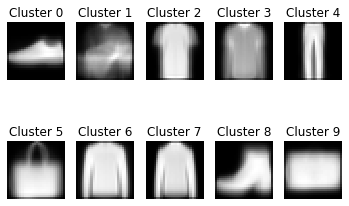

In [0]:
for i in range(n_clusters):
  plt.subplot(2, 5, i + 1)
  plt.imshow(kmeans_best.cluster_centers_[i][:].reshape(28, 28), cmap='gray')
  plt.title('Cluster ' + str(i))
  plt.axis('off')

### Predicting clusters for the training and test set images

In [0]:
Y_pred_train_km = kmeans_best.predict(X_train).reshape(X_train.shape[0], 1)
Y_pred_test_km = kmeans_best.predict(X_test).reshape(X_test.shape[0], 1)

In [0]:
print("ANALYSIS BEFORE ADJUSTING THE CLUSTER LABELS\n")

print("Accuracy on the training set -", get_accuracy(Y_train, Y_pred_train_km), "\n")
print("Confusion Matrix for performance on the training set -\n", get_confusion_matrix(Y_train, Y_pred_train_km))

ANALYSIS BEFORE ADJUSTING THE CLUSTER LABELS

Accuracy on the training set - 0.03298333333333334 

Confusion Matrix for performance on the training set -
 [[   2  451 3410 1703  175   29  173   39    0   18]
 [   0  133  236  149 5408    0   28   44    0    2]
 [   1  435   84 1693    8   24 1884 1850    0   21]
 [   0  422 1706  647 3143    8   17   53    1    3]
 [   0  209  711  931  148   26  929 3033    0   13]
 [1452 3988    3   49    1   12    0    0  485   10]
 [   6  642 1035 2070   50   19  940 1194    2   42]
 [5069  636    0    1    0    0    0    0  288    6]
 [ 291  430   21  319   20 2434  284   38    8 2155]
 [ 681  198    8   62    3    3    1    9 5030    5]]


### Adjusting the predicted train and test set labels

In [0]:
Y_pred_train_km, adjusted_labels = get_adjusted_labels(Y_train, Y_pred_train_km)

# replacing the labels 0 to 9 with 10 to 19
for i in range(10):
  Y_pred_test_km = np.where(Y_pred_test_km == i, i + 10, Y_pred_test_km)
# replacing the labels 10 to 19 with the adjusted ones
for i in range(10):
  Y_pred_test_km = np.where(Y_pred_test_km == i + 10, adjusted_labels[i], Y_pred_test_km)

### Evaluating the K-Means model

#### On the training set

In [0]:
print("ANALYSIS FOR K-MEANS CLUSTERING ALGORITHM\n")

print("Accuracy on the training set -", get_accuracy(Y_train, Y_pred_train_km), "\n")
print("Confusion Matrix for performance on the training set -\n", get_confusion_matrix(Y_train, Y_pred_train_km))

ANALYSIS FOR K-MEANS CLUSTERING ALGORITHM

Accuracy on the training set - 0.5388166666666667 

Confusion Matrix for performance on the training set -
 [[3410  175  173   18   39  451 1703    2   29    0]
 [ 236 5408   28    2   44  133  149    0    0    0]
 [  84    8 1884   21 1850  435 1693    1   24    0]
 [1706 3143   17    3   53  422  647    0    8    1]
 [ 711  148  929   13 3033  209  931    0   26    0]
 [   3    1    0   10    0 3988   49 1452   12  485]
 [1035   50  940   42 1194  642 2070    6   19    2]
 [   0    0    0    6    0  636    1 5069    0  288]
 [  21   20  284 2155   38  430  319  291 2434    8]
 [   8    3    1    5    9  198   62  681    3 5030]]


#### On the test set

In [0]:
print("ANALYSIS FOR K-MEANS CLUSTERING ALGORITHM\n")

print("Accuracy on the test set -", get_accuracy(Y_test, Y_pred_test_km), "\n")
print("Confusion Matrix for performance on the test set -\n", get_confusion_matrix(Y_test, Y_pred_test_km))

ANALYSIS FOR K-MEANS CLUSTERING ALGORITHM

Accuracy on the test set - 0.5455 

Confusion Matrix for performance on the test set -
 [[588  24  36   5   7  67 267   1   5   0]
 [ 49 888   2   0  11  20  30   0   0   0]
 [ 14   4 313   2 289  49 325   0   4   0]
 [280 491   3   2  12  75 134   0   3   0]
 [102  25 184   2 511  36 135   0   5   0]
 [  0   0   0   3   0 682   8 228   0  79]
 [185  11 143  13 192 100 356   0   0   0]
 [  0   0   0   1   0  83   0 866   0  50]
 [  3   4  61 348   7  69  55  48 405   0]
 [  0   0   1   2   1  36   7 107   2 844]]


## Task 2: Using Auto-Encoder based K-Means to cluster the Fashion MNIST data space

### Defining hyperparameters for training the autoencoder

In [0]:
# number of epochs for training
epochs_train = 100

# mini-batch size
minibatch_size = 256

### Defining the multi-layer autoencoder architecture

In [0]:
autoencoder = keras.Sequential()

autoencoder.add(keras.layers.Dense(512, activation='relu', input_shape = (784, )))
autoencoder.add(keras.layers.Dense(256, activation='relu'))
autoencoder.add(keras.layers.Dense(128, activation='relu'))
autoencoder.add(keras.layers.Dense(49, activation='sigmoid'))

autoencoder.add(keras.layers.Dense(128, activation='relu'))
autoencoder.add(keras.layers.Dense(256, activation='relu'))
autoencoder.add(keras.layers.Dense(784, activation='sigmoid'))

# layer number from which the decoder starts
decoder_layer = 4

# display the autoencoder architecture
autoencoder.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 49)                6321      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               6400      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)           

### Compiling the autoencoder

In [0]:
autoencoder.compile(loss='mean_squared_error', optimizer='Adam')

### Training the autoencoder

In [0]:
autoencoder_fit = autoencoder.fit(
    X_train,
    X_train,
    batch_size = minibatch_size,
    epochs = epochs_train,
    validation_data=(X_test, X_test))




Train on 60000 samples, validate on 10000 samples
Epoch 1/100





60000/60000 [==============================] - 6s 96us/step - loss: 0.0611 - val_loss: 0.0383
Epoch 2/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0294 - val_loss: 0.0244
Epoch 3/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0230 - val_loss: 0.0218
Epoch 4/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0204 - val_loss: 0.0194
Epoch 5/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0186 - val_loss: 0.0183
Epoch 6/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0175 - val_loss: 0.0170
Epoch 7/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0165 - val_loss: 0.0162
Epoch 8/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.0159 - val_loss: 0.0158
Epoch 9/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0153 - val_l

### Comparing loss for training and validation sets

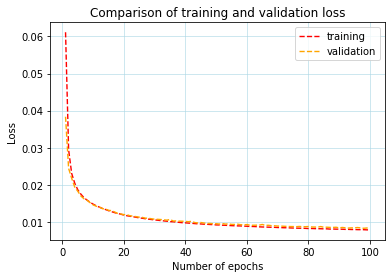

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(1, epochs_train + 1), autoencoder_fit.history['loss'], color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs_train + 1), autoencoder_fit.history['val_loss'], color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('autoenc_km_train_vs_val_loss.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Finding the encoded representations of training images

In [0]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[decoder_layer - 1].output)
X_train_enc = encoder.predict(X_train)

### Implementing K-Means on the encoded training images

In [0]:
kmeans_enc = KMeans(n_clusters=n_clusters, n_init=10)
kmeans_enc.fit(X_train_enc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Visualizing the Auto-Encoder based K-Means cluster centroids

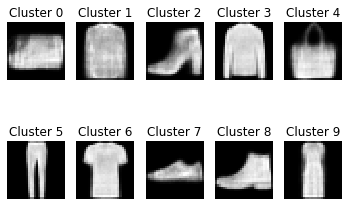

In [0]:
# building the decoder network
input_shape = autoencoder.layers[decoder_layer].get_input_shape_at(0)
input_layer = Input(shape=(input_shape[1], ))
network = input_layer
for layer in autoencoder.layers[decoder_layer:]:
  network = layer(network)
decoder = Model(input_layer, network)

# decoding the encoded cluster centres
cluster_centers_dec_km = decoder.predict(kmeans_enc.cluster_centers_)

# viewing the cluster centres
for i in range(n_clusters):
  plt.subplot(2, 5, i + 1)
  plt.imshow(cluster_centers_dec_km[i][:].reshape(28, 28), cmap='gray')
  plt.title('Cluster ' + str(i))
  plt.axis('off')

### Predicting clusters for the encoded training and test set images

In [0]:
Y_pred_train_enc_km = kmeans_enc.predict(encoder.predict(X_train))
Y_pred_test_enc_km = kmeans_enc.predict(encoder.predict(X_test))

### Adjusting the predicted train and test set labels

In [0]:
Y_pred_train_enc_km, adjusted_labels_enc_km = get_adjusted_labels(Y_train, Y_pred_train_enc_km)

# replacing the labels 0 to 9 with 10 to 19
for i in range(10):
  Y_pred_test_enc_km = np.where(Y_pred_test_enc_km == i, i + 10, Y_pred_test_enc_km)
# replacing the labels 10 to 19 with the adjusted ones
for i in range(10):
  Y_pred_test_enc_km = np.where(Y_pred_test_enc_km == i + 10, adjusted_labels_enc_km[i], Y_pred_test_enc_km)

### Evaluating the Auto-Encoder based K-Means model

#### On the training set

In [0]:
print("ANALYSIS FOR AUTO-ENCODER BASED K-MEANS CLUSTERING ALGORITHM\n")

print("Accuracy on the training set -", get_accuracy(Y_train, Y_pred_train_enc_km), "\n")
print("Confusion Matrix for performance on the training set -\n", get_confusion_matrix(Y_train, Y_pred_train_enc_km))

ANALYSIS FOR AUTO-ENCODER BASED K-MEANS CLUSTERING ALGORITHM

Accuracy on the training set - 0.5283166666666667 

Confusion Matrix for performance on the training set -
 [[3585    2   37  586   98    2 1678    1   11    0]
 [  45 4800    1  788   25    0  341    0    0    0]
 [  51    1   23   54 3191    2 2678    0    0    0]
 [ 165  251    5 4776  135    0  662    0    6    0]
 [   9    3   15  762 3882    0 1317    0   12    0]
 [   0    1  736    8    0 1801  138 3074    0  242]
 [ 883    2   56  325 1687    0 3046    0    1    0]
 [   0    0  732    0    0   19   10 4332    1  906]
 [  22    3 2483  101   48    2  790   32 2519    0]
 [   0    0  642    2    0 2213  115   93    0 2935]]


#### On the test set

In [0]:
print("ANALYSIS FOR AUTO-ENCODER BASED K-MEANS CLUSTERING ALGORITHM\n")

print("Accuracy on the test set -", get_accuracy(Y_test, Y_pred_test_enc_km), "\n")
print("Confusion Matrix for performance on the test set -\n", get_confusion_matrix(Y_test, Y_pred_test_enc_km))

ANALYSIS FOR AUTO-ENCODER BASED K-MEANS CLUSTERING ALGORITHM

Accuracy on the test set - 0.5296 

Confusion Matrix for performance on the test set -
 [[603   0   8  88  22   1 277   1   0   0]
 [  4 788   0 136   4   0  68   0   0   0]
 [ 10   0   5  10 498   0 477   0   0   0]
 [ 31  42   1 768  20   0 137   0   1   0]
 [  0   0   2 107 672   0 215   0   4   0]
 [  0   0 104   0   0 326  23 495   0  52]
 [151   1  14  61 271   0 501   0   1   0]
 [  0   0 125   0   0   3   0 704   0 168]
 [  3   1 390  17  11   0 153   7 418   0]
 [  0   0 103   1   0 350  23  12   0 511]]


## Task 3: Using Auto-Encoder based GMM to cluster the Fashion MNIST data space

### Implementing GMM on the encoded training images

In [0]:
gmm_enc = GaussianMixture(n_components=n_clusters)
gmm_enc.fit(X_train_enc)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=1, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

### Visualizing the Auto-Encoder based GMM cluster centroids

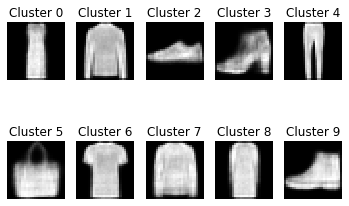

In [0]:
# decoding the encoded cluster centres
cluster_centers_dec_gmm = decoder.predict(gmm_enc.means_)

# viewing the cluster centres
for i in range(n_clusters):
  plt.subplot(2, 5, i + 1)
  plt.imshow(cluster_centers_dec_gmm[i][:].reshape(28, 28), cmap='gray')
  plt.title('Cluster ' + str(i))
  plt.axis('off')

### Predicting clusters for the encoded training and test set images

In [0]:
Y_pred_train_enc_gmm = gmm_enc.predict(encoder.predict(X_train))
Y_pred_test_enc_gmm = gmm_enc.predict(encoder.predict(X_test))

### Adjusting the predicted train and test set labels

In [0]:
Y_pred_train_enc_gmm, adjusted_labels_enc_gmm = get_adjusted_labels(Y_train, Y_pred_train_enc_gmm)

# replacing the labels 0 to 9 with 10 to 19
for i in range(10):
  Y_pred_test_enc_gmm = np.where(Y_pred_test_enc_gmm == i, i + 10, Y_pred_test_enc_gmm)
# replacing the labels 10 to 19 with the adjusted ones
for i in range(10):
  Y_pred_test_enc_gmm = np.where(Y_pred_test_enc_gmm == i + 10, adjusted_labels_enc_gmm[i], Y_pred_test_enc_gmm)

### Evaluating the Auto-Encoder based GMM

#### On the training set

In [0]:
print("ANALYSIS FOR AUTO-ENCODER BASED K-MEANS CLUSTERING ALGORITHM\n")

print("Accuracy on the training set -", get_accuracy(Y_train, Y_pred_train_enc_gmm), "\n")
print("Confusion Matrix for performance on the training set -\n", get_confusion_matrix(Y_train, Y_pred_train_enc_gmm))

ANALYSIS FOR AUTO-ENCODER BASED K-MEANS CLUSTERING ALGORITHM

Accuracy on the training set - 0.5734166666666667 

Confusion Matrix for performance on the training set -
 [[4246    0  408  171   13  351  791    1   14    5]
 [   1 5142  105  263    1   32  456    0    0    0]
 [  25    0 2348   16 3388   92  123    0    5    3]
 [  67    0  163 3494   18   83 2174    0    1    0]
 [  10    0 1304   66 3272   69 1270    0    8    1]
 [   0    0    0    0    0 2946    0 2970    0   84]
 [1097    0 1385   73 2598  155  675    0    7   10]
 [   0    0    0    0    0   94    0 4771    0 1135]
 [   2    0  418   30    3  428   23   41 2929 2126]
 [   0    0    0    0    0 1269    1  148    0 4582]]


#### On the test set

In [0]:
print("ANALYSIS FOR AUTO-ENCODER BASED GMM CLUSTERING ALGORITHM\n")

print("Accuracy on the test set -", get_accuracy(Y_test, Y_pred_test_enc_gmm), "\n")
print("Confusion Matrix for performance on the test set -\n", get_confusion_matrix(Y_test, Y_pred_test_enc_gmm))

ANALYSIS FOR AUTO-ENCODER BASED GMM CLUSTERING ALGORITHM

Accuracy on the test set - 0.5761 

Confusion Matrix for performance on the test set -
 [[689   0  84  27   3  62 128   1   5   1]
 [  0 850  17  45   0   2  86   0   0   0]
 [  9   0 399   1 555  12  23   0   0   1]
 [ 11   0  38 557   4  13 375   0   2   0]
 [  0   0 229  14 557  16 184   0   0   0]
 [  0   0   0   0   0 524   0 457   0  19]
 [186   0 226  15 413  21 130   0   2   7]
 [  0   0   0   0   0   8   0 778   0 214]
 [  0   0  90   7   2  65   1   8 493 334]
 [  0   0   0   0   0 197   0  19   0 784]]
